In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds


In [2]:
print(tf.__version__)
print(np.__version__)

2.8.0
1.21.5


In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 사용할 데이터셋 가져오기
- standford_dogs 사용
- 120견종의 이미지가 포함되어 있으면 총 20,580장의 이미지에서 12000장은 train set, 8580장은 test set으로 구성


In [4]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

In [5]:
#데이터 갯수
print(tf.data.experimental.cardinality(ds_train))

tf.Tensor(12000, shape=(), dtype=int64)


In [6]:
num_classes = ds_info.features["label"].num_classes

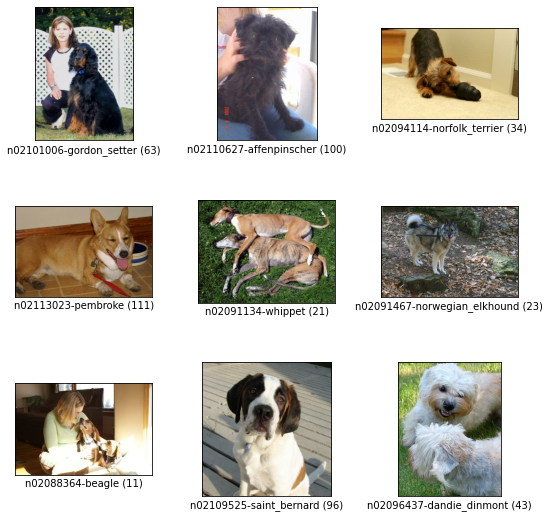

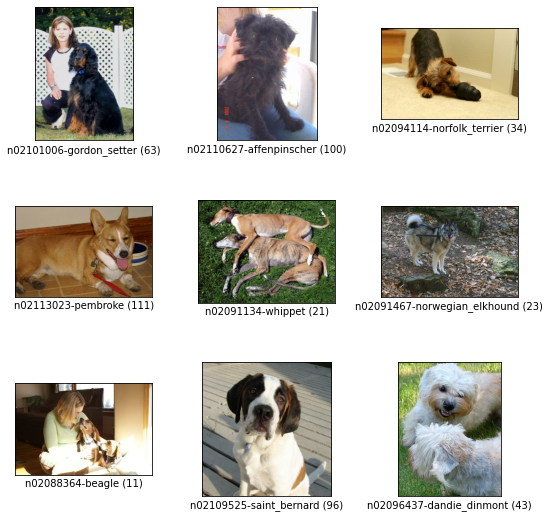

In [7]:
tfds.show_examples(ds_train, ds_info)

In [8]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)

    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds


In [9]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
#ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

Test 하기 위한 이미지 

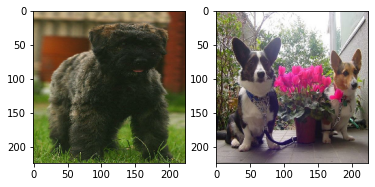

In [10]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        #break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [11]:
image_a.shape[0],image_a.shape[1]

(224, 224)

## Cutmix 사용 시 주의사항
- CutMix는 배치 안에 있는 이미지끼리만 섞는 과정이기 때문에 미리 배치 단위로 데이터셋을 정렬 후 CutMix가 적용되어야 한다.

### CutMix 간단 설명
- CutMix는 이미지 데이터를 자르고 섞는 것으로 일정 영역을 잘라서 붙여주는 방법
- CutMix는 이미지를 섞는 부분과 섞은 이미지에 맞추어 라벨을 섞는 부분을 포함


## CutMix 구현하기
### 1) 이미지 섞기
- 가장 먼저 두개의 이미지를 섞어주는 작업 필요
- 배치 내의 이미지를 두개 골라서 섞어준다. 이때 이미지에서 잘라서 섞어주는 영역을 바운딩 박스(bounding box)라고 함
- CutMix공식 repo에서는 width, height가 가반적으로 적용할 수 있도록 구현해야함

### get_clip_box 함수
바탕이미지 image_a에서 바운딩 박스 바깥쪽 영역을 다른 이미지 image_b에서 바운딩 박스 안쪽 영역을 가져와서 합치는 함수
- tf.random.uniform: 원하는 형태의 랜덤값을 가지는 배열 생성

In [12]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1] # width
    image_size_y = image_a.shape[0] #height
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)
    #tf.random.uniform (shape, min, max, dtype)으로 지정
    # shape은 [] 으로 최소 0 ~ 최대 image_size_x,y를 가지는 배열 생성하며 dtype은 tf.int32로 함

    # get width, height of box
    #tf.cast(조건) -> 조건에 따라 1 or 0을 return함 , dtype이 int32형이기 때문에 결과값에 부동소수점이 포함되어 있으면 소수점 뒷부분은 버림
    # image_a에서 자를 영역을 random하게 선정함
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

In [13]:
x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(54, shape=(), dtype=int32) tf.Tensor(128, shape=(), dtype=int32)
y :  tf.Tensor(23, shape=(), dtype=int32) tf.Tensor(84, shape=(), dtype=int32)


### 2개의 이미지 붙이기

In [14]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

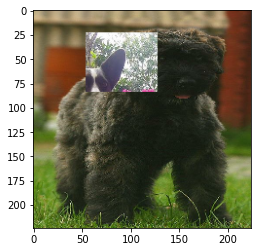

In [15]:
mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

### 2) label 섞기
- 이미지를 섞었다면 라벨도 맞게 섞어줘야 한다. 
- CutMix에서는 면적에 비례해서 라벨을 섞어여 한다. 섞인 이미지의 전체 이미지 대비 비율을 계산해서 두가지 라벨의 비율로 더해주는 작업
- 라벨 벡터는 보통 클래스를 표시하듯 클래스 1개만 1의 값을 가지는 One-Hot 인코딩이 아니라 A와 B 클래스에 해당하는 인덱스에 각 배분하는 방식 사용

#### tf.one_hot 인코딩
- 인덱스를 입력받아 one-hot 인코딩 결과를 리턴
- 각 라벨에 해당하는 인덱스를 해당 위치만 1로 매핑하고 나머지는 0으로 매핑한 벡터로 표현
- tf.one_hot(라벨 인덱스 목록, 라벨 개수)


In [16]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)
    # 전제 이미지 중 붙여놓은 이미지의 %만큼 label 적용하기 위한 비율 계산

    if len(label_a.shape)==0:# 배열 형태가 아닌 경우 즉, int 형을 가지는 값일 경우?
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

In [17]:
mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

In [18]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []
    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

## Mixup 구현
- 두개의 이미지의 픽셀별 값을 비율에 따라 섞어주는 방식
- 두 이미지를 섞을 비율을 일정한 범위 내에서 랜덤하게 뽑고 해당 비율값에 따라 두 이미지의 픽셀별 값과 라벨을 섞어줌

In [19]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    # 0~1범위 내의 값을 random하게 가져옴
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

In [20]:
def mixup(image,label,batch_size=16,img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []
    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        img,mixlabel = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(img)
        mixed_labels.append(mixlabel)
    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels    

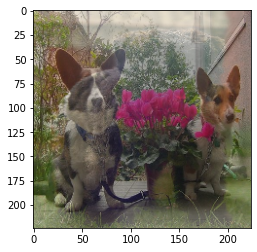

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.41131818 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

In [21]:
mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

In [22]:
mixed_img

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.5488689 , 0.5151923 , 0.44596624],
        [0.55442166, 0.5445962 , 0.38698554],
        [0.65498203, 0.6633581 , 0.43375224],
        ...,
        [0.56636035, 0.4992796 , 0.4810926 ],
        [0.50342935, 0.43103597, 0.41838357],
        [0.47846586, 0.40215087, 0.39873266]],

       [[0.7149581 , 0.68355453, 0.6182841 ],
        [0.8664661 , 0.8475541 , 0.73127437],
        [0.6303648 , 0.63168657, 0.45714605],
        ...,
        [0.49709857, 0.4227562 , 0.40657824],
        [0.57805943, 0.49848318, 0.48812404],
        [0.5107381 , 0.43386823, 0.430635  ]],

       [[0.68001586, 0.6755891 , 0.464964  ],
        [0.68227756, 0.6849661 , 0.48420852],
        [0.7729267 , 0.77957475, 0.577872  ],
        ...,
        [0.57333213, 0.48850828, 0.47677335],
        [0.53084403, 0.44091126, 0.43984035],
        [0.48418674, 0.40491235, 0.40248066]],

       ...,

       [[0.6127749 , 0.6594318 , 0.50595677],
        [0.58

In [23]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [24]:
ds_train
ds = ds_train.map(
            normalize_and_resize_img,
        )

In [25]:
ds = ds.batch(16)
ds = ds.map(
            mixup,
            num_parallel_calls=2
        )

In [26]:
ds

<ParallelMapDataset element_spec=(TensorSpec(shape=(16, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(16, 120), dtype=tf.float32, name=None))>

In [27]:
def show(image, label):
  plt.figure()
  plt.imshow(image)
  plt.title(label.numpy().decode('utf-8'))
  plt.axis('off')

In [28]:
def onehot(image,label,num_classes=120):
    en_label = tf.one_hot(label,num_classes)
    return image,tf.cast(en_label, tf.float32)

# Mixup, CutMix 성능 비교하기

## 1. Augmentation 적용한 데이터셋 만들기

In [29]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False,with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    print("normalize")
        
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
        print("augment")
        
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        ) 
        print("cutmix")

    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
        print("mixup")
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
        print("onehot")

    # if is_test or not with_aug:
    #     ds = ds.map(
    #         onehot,
    #         num_parallel_calls=2
    #     )
    #     print('onehot')

    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds


In [30]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

In [31]:
num_classes = ds_info.features["label"].num_classes
num_classes

120

In [32]:
print(tf.data.experimental.cardinality(ds_train))

tf.Tensor(12000, shape=(), dtype=int64)


In [33]:
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(8580, shape=(), dtype=int64)


## augmentation 사용 여부에 따른 모델 실행

In [34]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True) # 일반 aug 적용


normalize
onehot
normalize
augment
onehot


In [35]:
ds_train_cutmix = apply_normalize_on_dataset(ds_train,with_aug=True,with_cutmix=True) # cutmix 적용
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_aug=True,with_mixup = True) # mixup 적용
ds_test_ = apply_normalize_on_dataset(ds_test, is_test=True) # test 데이터 


normalize
augment
cutmix
normalize
augment
mixup
normalize
onehot


In [36]:
ds_train_mixup

<PrefetchDataset element_spec=(TensorSpec(shape=(16, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(16, 120), dtype=tf.float32, name=None))>

shape (batch_size, width, height, depth)

In [37]:
ds_train_aug

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.float32, name=None))>

In [38]:
ds_test_

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.float32, name=None))>

# 모델 만들기
- ResNet50 사용

In [39]:
EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
#EPOCH = 3

In [40]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False, #  FC layer를 포함할 것인지 여부 결정
        weights='imagenet', # imagenet으로 트레이닝된 모델을 불러옴
        input_shape=(224,224,3),
        pooling='avg', #AvergePooling 사용
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [41]:
history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test_,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 111s 130ms/step - loss: 2.1895 - accuracy: 0.4527 - val_loss: 3.5115 - val_accuracy: 0.1844
Epoch 2/20
750/750 [==============================] - 95s 127ms/step - loss: 0.7481 - accuracy: 0.7943 - val_loss: 1.1750 - val_accuracy: 0.6552
Epoch 3/20
750/750 [==============================] - 96s 127ms/step - loss: 0.2426 - accuracy: 0.9460 - val_loss: 0.9397 - val_accuracy: 0.7288
Epoch 4/20
750/750 [==============================] - 95s 127ms/step - loss: 0.0815 - accuracy: 0.9911 - val_loss: 0.9273 - val_accuracy: 0.7319
Epoch 5/20
750/750 [==============================] - 95s 127ms/step - loss: 0.0407 - accuracy: 0.9970 - val_loss: 0.9560 - val_accuracy: 0.7304
Epoch 6/20
750/750 [==============================] - 96s 128ms/step - loss: 0.0165 - accuracy: 0.9998 - val_loss: 0.9180 - val_accuracy: 0.7427
Epoch 7/20
750/750 [==============================] - 96s 128ms/step - loss: 0.0096 - accuracy: 1.0000 - val_loss: 0.9241 - val_a

In [42]:
resnet50_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

resnet50_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)


history_resnet50_aug = resnet50_aug.fit(
    ds_train_aug, # augmentation 적용하는 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test_,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 108s 129ms/step - loss: 2.2865 - accuracy: 0.4322 - val_loss: 2.8279 - val_accuracy: 0.2916
Epoch 2/20
750/750 [==============================] - 96s 128ms/step - loss: 0.9562 - accuracy: 0.7273 - val_loss: 1.0895 - val_accuracy: 0.6769
Epoch 3/20
750/750 [==============================] - 96s 129ms/step - loss: 0.5057 - accuracy: 0.8617 - val_loss: 1.1287 - val_accuracy: 0.6799
Epoch 4/20
750/750 [==============================] - 97s 129ms/step - loss: 0.2730 - accuracy: 0.9318 - val_loss: 1.9158 - val_accuracy: 0.5217
Epoch 5/20
750/750 [==============================] - 97s 130ms/step - loss: 0.1482 - accuracy: 0.9703 - val_loss: 1.0621 - val_accuracy: 0.7081
Epoch 6/20
750/750 [==============================] - 98s 130ms/step - loss: 0.0795 - accuracy: 0.9893 - val_loss: 0.9575 - val_accuracy: 0.7344
Epoch 7/20
750/750 [==============================] - 97s 130ms/step - loss: 0.0919 - accuracy: 0.9830 - val_loss: 1.0087 - val_accuracy: 0.

In [49]:
type(ds_train_no_aug), type(ds_train_mixup)

(tensorflow.python.data.ops.dataset_ops.PrefetchDataset,
 tensorflow.python.data.ops.dataset_ops.PrefetchDataset)

In [51]:
ds_train_no_aug

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.float32, name=None))>

In [59]:
no_aug_concat_mixup = ds_train_no_aug.concatenate(ds_train_mixup)
no_aug_concat_mixup

<ConcatenateDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.float32, name=None))>

In [60]:
aug_resnet50_mixup = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

aug_resnet50_mixup.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)


history_resnet50_mixup = aug_resnet50_mixup.fit(
    no_aug_concat_mixup, #ds_train_mixup, # mixup 적용하는 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test_,
    verbose=1,
    use_multiprocessing=True,
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
750/750 [==============================] - 111s 131ms/step - loss: 2.2222 - accuracy: 0.4449 - val_loss: 2.9546 - val_accuracy: 0.2747
Epoch 2/20
750/750 [==============================] - 99s 132ms/step - loss: 0.6715 - accuracy: 0.8230 - val_loss: 0.9932 - val_accuracy: 0.7069
Epoch 3/20
750/750 [==============================] - 98s 130ms/step - loss: 0.1871 - accuracy: 0.9648 - val_loss: 0.9180 - val_accuracy: 0.7271
Epoch 4/20
750/750 [==============================] - 98s 131ms/step - loss: 0.0499 - accuracy: 0.9968 - val_loss: 0.9101 - val_accuracy: 0.7354
Epoch 5/20
750/750 [==============================] - 98s 131ms/step - loss: 0.0339 - accuracy: 0.9981 - val_loss: 0.9343 - val_accuracy: 0.7372
Epoch 6/20
750/750 [==============================] - 98s 131ms/step - loss: 0.0196 - accuracy: 0.9994 - val_loss: 0.9243 - val_accuracy: 0.7431
Epoch 7/20
750/750 [==============================] - 99s 132ms/step - loss: 0.0113 - accuracy: 0.9996 - val_loss: 0.9266 - val_a

In [61]:
no_aug_concat_cutmix = ds_train_no_aug.concatenate(ds_train_cutmix)
no_aug_concat_cutmix

<ConcatenateDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.float32, name=None))>

In [62]:
aug_resnet50_cutmix = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

aug_resnet50_cutmix.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_cutmix = aug_resnet50_cutmix.fit(
    no_aug_concat_cutmix, # augmentation 적용하는 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test_,
    verbose=1,
    use_multiprocessing=True,
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
750/750 [==============================] - 114s 133ms/step - loss: 2.2109 - accuracy: 0.4434 - val_loss: 3.5549 - val_accuracy: 0.1941
Epoch 2/20
750/750 [==============================] - 96s 127ms/step - loss: 0.6776 - accuracy: 0.8183 - val_loss: 1.0691 - val_accuracy: 0.6910
Epoch 3/20
750/750 [==============================] - 95s 127ms/step - loss: 0.2978 - accuracy: 0.9298 - val_loss: 0.9889 - val_accuracy: 0.7092
Epoch 4/20
750/750 [==============================] - 95s 127ms/step - loss: 0.0830 - accuracy: 0.9890 - val_loss: 0.9408 - val_accuracy: 0.7276
Epoch 5/20
750/750 [==============================] - 96s 129ms/step - loss: 0.0250 - accuracy: 0.9987 - val_loss: 0.9141 - val_accuracy: 0.7381
Epoch 6/20
750/750 [==============================] - 96s 128ms/step - loss: 0.0174 - accuracy: 0.9997 - val_loss: 0.9209 - val_accuracy: 0.7401
Epoch 7/20
750/750 [==============================] - 96s 128ms/step - loss: 0.0101 - accuracy: 0.9998 - val_loss: 0.9515 - val_a

# 훈련과정 시각화
## 각 데이터만 활용하여 학습

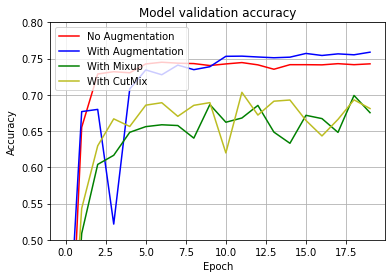

In [46]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'g')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], color='#bcbd22')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation','With Mixup','With CutMix'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

## 데이터 추가하여 적용

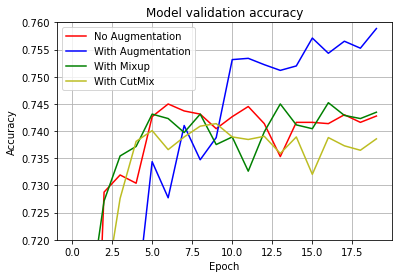

In [64]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'g')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], color='#bcbd22')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation','With Mixup','With CutMix'], loc='upper left')
plt.grid(True)
#plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

# 최종 결과
- Augmentation 기법을 활용하여 학습 데이터을 다양한 이미지로 변경하여 학습을 진행하였다.
- 일반 Augmentation을 적용하여 학습한 결과  Aug을 적용하지 않는 모델보다 더욱 좋은 결과가 나타났다. 또한, Augmentaion 기법 중 하나인 Mixup과 CutMix를 사용하여 ResNet50모델에 적용하여 학습을 진행한 결과 학습 진행 초반에는 기본 Aug에 비해 더 좋은 성능이 나타났지만 epoch=10을 기점으로는 기본 Aug 적용한 모델이 더 좋은 성능이 나온 것을 확인하였다.
- 처음에는 CutMix와 MixUp 적용한 모델의 학습 데이터량이 작아 학습이 원활하게 진행되지 않았다고 판단하여 가장 좋은 성능을 나타내는 기본 Aug적용한 데이터를 추가하여 학습을 진행하였다.
<br/>
그 결과 CutMix와 MixUp만 학습한 모델의 val_acc보다 더 높은 값을 가져오는 것을 확인할 수 있었다.
<br/>
하지만 CutMix의 경우 Aug적용하지 않은 모델에 비해 epoch=5 시점부터 val_acc 값이 더 낮게 나온 것을 보고 CutMix의 경우 추가로 데이터 구성하고 다른 하이퍼파라미터를 조정해야 할 것 같다.
